In [278]:
import sys
import matplotlib.pyplot as plt
import networkx as nx
from datetime import datetime, timedelta
from random import randrange, randint
import numpy as np
import math
from tqdm import tqdm
import csv
import random
import string
import itertools
import matplotlib.pyplot as plt

In [279]:
# Задаём число аккаунтов в сети и общее число токенов

n = 1500 
G = nx.complete_graph(n)
token_supply = 1000000000
token_distribution = {'genesis':1}


In [280]:
counter = 9

In [281]:
def random_n_digits(n):
    range_start = 10**(n-1)
    range_end = (10**n)-1
    return randint(range_start, range_end)

def generate_addresses(graph):
    for node in graph.nodes():
        graph.node[node]['address'] = 'g'+str(random_n_digits(4))+str(random.choice(string.ascii_lowercase))+\
        str(random_n_digits(4))+random.choice(string.ascii_lowercase)+str(random_n_digits(4))

In [282]:
# Распределяем роли в сети и их количество

ro = [0.25, 0.25, 0.5]

roles = {'genesis':1, 'exchange':1,
             'buyer':int(ro[0]*n), 
             'seller':int(ro[1]*n), 
             'hodler':int(n-(sum(ro[0:2]))*n)-1}


for node in G.nodes()[0:roles['genesis']]:
    G.node[node]['account_type'] = 'genesis'
for node in G.nodes()[roles['genesis']:roles['genesis']+roles['exchange']]:
    G.node[node]['account_type'] = 'exchange'
for node in G.nodes()[roles['genesis']+roles['exchange']:roles['genesis']+roles['exchange']+roles['buyer']]:
    G.node[node]['account_type'] = 'buyer'
for node in G.nodes()[roles['genesis']+roles['exchange']+roles['buyer']:
                        roles['genesis']+roles['exchange']+roles['buyer']+roles['seller']]:
    G.node[node]['account_type'] = 'seller'
for node in G.nodes()[roles['genesis']+roles['exchange']+roles['buyer']+roles['seller']:n]:
    G.node[node]['account_type'] = 'hodler'


In [283]:
# Задаём стартовую пустую историю транзакций между каждой парой пользователей

def set_initial_history(graph):
    for edge in G.edges():
        if edge[0] < edge[1]:
            G.edge[edge[0]][edge[1]]['tx_history'] = []
        
    
# Транзакция на ребре подразумевает, что первый аккаунт - отправитель, второй - получатель

def transaction(graph, edge, amount, amount_threshold, timestamp):
           
    if (graph.node[edge[0]]['balance'] >= (amount_threshold+20) ) and\
    (graph.node[edge[0]]['balance'] >= (amount+20)) and\
    (amount_threshold) <= (amount):
        
        graph.node[edge[0]]['balance'] -= (amount+20)
        graph.node[edge[1]]['balance'] += amount
        graph.node[edge[0]]['send'] += 1
        graph.node[edge[1]]['receive'] += 1
        
    
        graph.edge[edge[0]][edge[1]]['tx_history'].append({'timestamp':timestamp,'from and to':edge,'amount':amount})
            
        with open('transaction_history' + str(counter) + '.csv', 'a', newline='') as csvfile:
            writer = csv.writer(csvfile, delimiter=';')
            writer.writerow([datetime.fromtimestamp(timestamp).\
            strftime('%Y-%m-%dT%H:%M:%S'), graph.node[edge[0]]['address'], graph.node[edge[1]]['address'],\
            amount, fee])

In [284]:
'''
Первый вариант - генерируем времена транзакций с произвольными промежутками времени, i - количество транзакций
'''

def random_date(start,i):
    current = start
    while i >= 0:
        current = current + timedelta(minutes=randrange(10))
        yield current
        i-=1

'''
Второй вариант задания таймстампов - это уплотнение активности. Мы рассмотрим равномерную торговлю, экспоненциально
растущую торговлю, а также уплотнение торговли где-то посередине, задавая различные веса временным промежуткам
'''

#Делим интервал на желаемое число частей
def interval_divide(startDate, endDate, intervals):
    min = int(datetime.strptime(startDate, '%Y-%m-%d %H:%M:%S').strftime("%s"))
    max = int(datetime.strptime(endDate, '%Y-%m-%d %H:%M:%S').strftime("%s"))
    interval_size = round((max - min) / intervals)
    intervals_list = []
    start = min
    for start in range(min, max, interval_size):
        end = start + interval_size
        intervals_list.append([start, end])
    #print(intervals_list)
    return intervals_list

#Каждому интервалу с заданными вручную весами ставим в соответствие рандомную точку из этого интервала
def generate_weighted_activity(intervals, weights):
    weights = [w/sum(weights) for w in weights]
    tx_weighted_ts = []
    assert len(intervals) == len(weights)
    weighted_intervals = list(random.choices(intervals, weights, k=number_of_tx))
    for interval in weighted_intervals:
        tx_weighted_ts.append(random.uniform(interval[0], interval[1]))
    return tx_weighted_ts


In [285]:
def set_activity_count(graph, tx_number):
    for node in graph.nodes():
        if graph.node[node]['account_type'] == 'genesis':
            graph.node[node]['send'] = 0
            graph.node[node]['receive'] = 0
        
        if graph.node[node]['account_type'] == 'exchange':
            graph.node[node]['send'] = 0
            graph.node[node]['receive'] = 0
            
        if graph.node[node]['account_type'] == 'buyer':
            graph.node[node]['send'] = 0
            graph.node[node]['receive'] = 0
            
        if graph.node[node]['account_type'] == 'seller':
            graph.node[node]['send'] = 0
            graph.node[node]['receive'] = 0
            
        if graph.node[node]['account_type'] == 'hodler':
            graph.node[node]['send'] = 0
            graph.node[node]['receive'] = 0

def set_start_balances(graph, token_supply):
    for node in graph.nodes():
        if graph.node[node]['account_type'] == 'genesis':
            graph.node[node]['balance'] = token_distribution['genesis']*token_supply
        else:
            graph.node[node]['balance'] = 0

In [286]:
# b число бизнесов, активных в сети, c список количества клиентов у каждого бизнеса, а число атакующих
def clusters(graph, b, c):
    assert len(c) == b
    customers = {}
    b_list = list(random.sample(range(1, n), b))
    businesses = b_list
    non_businesses = [n for n in G.nodes()[2:] if n not in b_list]
    i = 0
    for business in businesses:
        customers[business] = list(random.sample(non_businesses, c[0]))
        i += 1
    return businesses, customers

In [287]:
def form_edges(businesses, clusters):
    c_to_b_edges = []
    b_to_c_edges = list(itertools.permutations(businesses, 2))
    for business in businesses:
        b_to_c_edges.append((business, 1))
        for customer in clusters[business]:
            c_to_b_edges.append((customer, business))
    return [b_to_c_edges, c_to_b_edges]

In [288]:
def generate_cluster_activity(graph, business_edges, timestamps):
    b1 = random.choices(business_edges, [0.4, 0.6], k=int(0.1*number_of_tx))
    b2 = [random.choice(el) for el in b1]
    b3 = random.sample(timestamps[20:], int(0.1*number_of_tx))
    business_ts = b3
    gen = [list(i) for i in zip(b2,b3)]
    return gen, business_ts

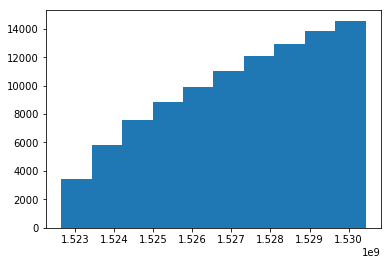

In [289]:
number_of_tx = 100000

#Задаём рост торговли в сети со временем
start = '2018-04-01 12:00:00'
end = '2018-07-01 12:00:00'
intervals = interval_divide(start, end, 100)
weights = [math.sqrt(0.75*t) for t in range(len(intervals))]

uneven_tx_ts = sorted(generate_weighted_activity(intervals, weights))

#Проверяем гистограмму числа транзакций в сети по временным интервалам
plt.hist(uneven_tx_ts)
plt.show()

In [290]:
exchange_count = 1
genesis_count = 1
buyer_count = 0
seller_count = 0
hodler_count = 0
business_count = 0

for node in G.nodes():
    if G.node[node]['account_type'] == 'buyer':
        buyer_count += 1
    if G.node[node]['account_type'] == 'seller':
        seller_count += 1
    if G.node[node]['account_type'] == 'hodler':
        hodler_count += 1

In [291]:
generate_addresses(G)
set_start_balances(G, token_supply)
set_initial_history(G)

#Сумма частоток для отправлений равна 1
send = {'exchange':0.005, 'genesis':0.005, 'buyer':0.33, 'seller':0.6, 'hodler':0.06}
set_activity_count(G, number_of_tx)

In [292]:
#Задаём число бизнесов и количество клиентов у каждого, клиенты могут пересекаться
client_list = [20, 30, 80, 20, 15, 25, 18, 10]
businesses, groups = clusters(G, 8, client_list)
b_edges = form_edges(businesses, groups)
business_transactions, business_ts = \
generate_cluster_activity(G, b_edges, uneven_tx_ts) 
business_transaction = sorted(business_transactions, key= lambda x: x[1])
business_ts = sorted(business_ts)

In [293]:
#Пишем баланс генезиса в стартовый баланс
with open('balances' + str(counter) + '.csv', 'a', newline='') as csvfile:
    writer = csv.writer(csvfile, quoting=csv.QUOTE_NONE, escapechar=' ')
    writer.writerow([G.node[0]['address'] + ';' + str(G.node[0]['balance'])])

In [294]:
def initial_transactions(number, timestamps, fee):
    start_nodes = random.sample(G.nodes()[2:], k=number)
    
    for i in range(number):
        
        with open('transaction_history' + str(counter) + '.csv', 'a', newline='') as csvfile:
            writer = csv.writer(csvfile, delimiter=';')
            amount = random.uniform(0.0045*token_supply,0.005*token_supply)
            timestamp = timestamps[i]
            if G.node[0]['balance'] > (amount+20):
                G.node[0]['balance'] -= (amount+20)
                G.node[start_nodes[i]]['balance'] += amount
                G.node[0]['send'] += 1
                G.node[start_nodes[i]]['receive'] +=1
                transaction_history.append([timestamp,(0,start_nodes[i]), amount])
                writer.writerow([datetime.fromtimestamp(timestamp).\
                strftime('%Y-%m-%dT%H:%M:%S'), G.node[0]['address'], G.node[start_nodes[i]]['address'],\
                amount, fee])
    

In [295]:
#Сумма равна единице
receive = {'exchange':0.05, 'genesis':0, 'buyer':0.55, 'seller':0.25, 'hodler':0.15}

node_receiver_weights = []
node_sender_weights = []

for node in G.nodes():
    if G.node[node]['account_type'] == 'genesis':
        node_sender_weights.append(send['genesis']/genesis_count)
        node_receiver_weights.append(receive['genesis']/genesis_count)
    if G.node[node]['account_type'] == 'exchange':
        node_sender_weights.append(send['exchange']/exchange_count)
        node_receiver_weights.append(receive['exchange']/exchange_count)
    if G.node[node]['account_type'] == 'buyer':
        node_sender_weights.append(send['buyer']/buyer_count)
        node_receiver_weights.append(receive['buyer']/buyer_count)
    if G.node[node]['account_type'] == 'seller':
        node_sender_weights.append(send['seller']/seller_count)
        node_receiver_weights.append(receive['seller']/seller_count)
    if G.node[node]['account_type'] == 'hodler':
        node_sender_weights.append(send['hodler']/hodler_count)
        node_receiver_weights.append(receive['hodler']/hodler_count)

        
#Нормируем веса так, чтобы их сумма равнялась [приблизительно] единице
norm_sender_weights = [float(i)/sum(node_sender_weights) for i in node_sender_weights]
norm_receiver_weights = [float(i)/sum(node_receiver_weights) for i in node_receiver_weights]


#Выбираем k отправителей и получателей с заданными весами, которые определяют их частоту появления в транзакции
send_list = list(random.choices(G.nodes(), norm_sender_weights, k=number_of_tx))
receive_list = list(random.choices(G.nodes(), norm_receiver_weights, k=number_of_tx))

#Формируем пары отправитель и получатель, удаляем пары, где они совпали
network_edges = [t for t in list(zip(send_list, receive_list)) if t[0] != t[1]]
bc_edges = random.choices(b_edges[0]+b_edges[1], k=int(0.1*number_of_tx))

In [296]:
#Запускаем транзакции между пользователями

amount_threshold = 1000
fee = 20
transaction_history = []
initial_transactions(200, uneven_tx_ts[0:200], fee)

b = 0
e = 0
for t in tqdm(uneven_tx_ts[200:]):
    
    if t in business_ts:
        
        b_edge = bc_edges[b]
        if G.node[b_edge[0]]['balance'] > amount_threshold + fee:
            amount = random.uniform(amount_threshold + fee, 0.4*G.node[b_edge[0]]['balance'])
        else:
            amount = 0
        
        if (amount_threshold + fee > G.node[b_edge[0]]['balance']) or (amount + fee > G.node[b_edge[0]]['balance']):
            pass
        else:
            transaction(G, b_edge, amount, amount_threshold, t)
            transaction_history.append([t, b_edge, amount])
        b += 1
            
    
    else:
        
        e_edge = network_edges[e]
        if G.node[e_edge[0]]['balance'] > amount_threshold + fee:
            amount = random.uniform(amount_threshold + fee, 0.3*G.node[e_edge[0]]['balance'])
        else: 
            amount = 0
        
        if (amount_threshold + fee > G.node[e_edge[0]]['balance']) or (amount + fee > G.node[e_edge[0]]['balance']):
            pass
        else:
            transaction(G, e_edge, amount, amount_threshold, t)
            transaction_history.append([t, e_edge, amount])
        e += 1
    

100%|██████████| 99800/99800 [01:11<00:00, 1395.99it/s]


In [297]:
print('Start:', start)
print('End:', end)
print('Accounts:', n)
print('Transactions:', number_of_tx)
print('Token supply:', token_supply)
print('Roles:', roles)
print('Sender and receiver weights:')
print(send)
print(receive)
print('Transaction fee:', 20)
print('Businesses:', len(businesses))
print('Client number:', client_list)
print('Businesses')
for node in businesses:
    print(G.node[node]['address'])
print('Business and regular transactions:')
print(b, e)

Start: 2018-04-01 12:00:00
End: 2018-07-01 12:00:00
Accounts: 1500
Transactions: 100000
Token supply: 1000000000
Roles: {'genesis': 1, 'exchange': 1, 'buyer': 375, 'seller': 375, 'hodler': 749}
Sender and receiver weights:
{'exchange': 0.005, 'genesis': 0.005, 'buyer': 0.33, 'seller': 0.6, 'hodler': 0.06}
{'exchange': 0.05, 'genesis': 0, 'buyer': 0.55, 'seller': 0.25, 'hodler': 0.15}
Transaction fee: 20
Businesses: 8
Client number: [20, 30, 80, 20, 15, 25, 18, 10]
Businesses
g6924y1671j9109
g6567s7669t5663
g3876a6905z5179
g5226b7996j5986
g4572u5286z2037
g3840w6875m5321
g1674i9707z6897
g4050f4167s9245
Business and regular transactions:
9987 89813


In [308]:
interval_volumes = []
for interval in intervals:
    interval_volumes.append(0)
    for event in transaction_history:
        if event[0] >= interval[0] and event[0] < interval[1]:
            interval_volumes[-1] += event[2]

In [309]:
len(interval_volumes)

100

In [299]:
interval_count = []
for interval in intervals:
    interval_count.append(0)
    for event in transaction_history:
        if event[0] >= interval[0] and event[0] < interval[1]:
            interval_count[-1] += 1

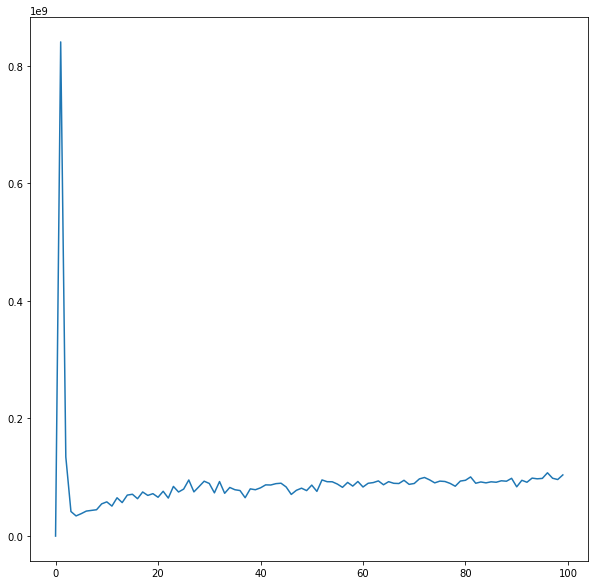

In [310]:
plt.plot(interval_volumes)
fig = plt.gcf()
fig.set_size_inches(10,10)
plt.show()

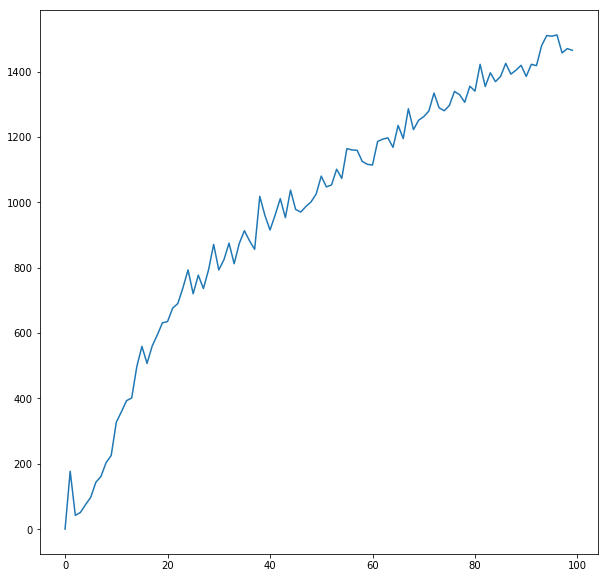

In [301]:
plt.plot(interval_count)
fig = plt.gcf()
fig.set_size_inches(10,10)
plt.show()

In [306]:
G.node[1]

{'account_type': 'exchange',
 'address': 'g1791u5098w9228',
 'balance': 5761919.024077264,
 'receive': 4651,
 'send': 423}

In [305]:
G.node[0]

{'account_type': 'genesis',
 'address': 'g6058z5762i1084',
 'balance': 795.0500170684647,
 'receive': 0,
 'send': 254}

In [137]:
hist = []
for edge in G.edges():
    if 222 in edge:
        if G.edge[edge[0]][edge[1]]['tx_history'] != []:
            for h in G.edge[edge[0]][edge[1]]['tx_history']:
                hist.append(h)
hist = sorted(hist, key = lambda x: x['timestamp'])
start_222 = 200000
print(len(hist))
for h in hist:
    if h['from and to'][0] == 222:
        start_222 -= h['amount']+20
    if h['from and to'][1] == 222:
        start_222 += h['amount']
    
    print(h)
    print('result:', start_222)

6
{'timestamp': 1523975747.2154882, 'from and to': (222, 51), 'amount': 177277.04470021292}
result: 22702.955299787078
{'timestamp': 1523976573.2775686, 'from and to': (222, 131), 'amount': 19799.93474234781}
result: 2883.0205574392676
{'timestamp': 1523978698.5222251, 'from and to': (222, 1138), 'amount': 2548.04284992198}
result: 314.9777075172874
{'timestamp': 1523985553.827286, 'from and to': (537, 222), 'amount': 7909.032163030277}
result: 8224.009870547565
{'timestamp': 1523986870.0526023, 'from and to': (222, 411), 'amount': 6592.858936936511}
result: 1611.150933611054
{'timestamp': 1523990405.8666484, 'from and to': (222, 1389), 'amount': 1441.607996925304}
result: 149.54293668574996


In [197]:
ff = 
l = 0
sent = 0
received = 0



for edge in G.edges():
    if 792 in edge:
        for h in G.edge[edge[0]][edge[1]]['tx_history']:
            if h['from and to'][0] == 792:
                
                ff -= (h['amount']+20)
                sent += (h['amount']+20)
                
            if h['from and to'][1] == 792:
                
                ff += h['amount']
                received += h['amount']
                

In [312]:
for node in G.nodes():
    if G.node[node]['address'] == 'g9824r2755i4703':
        print(node, G.node[node])

In [311]:
for node in G.nodes():
    print(G.node[node])

{'account_type': 'genesis', 'address': 'g6058z5762i1084', 'balance': 795.0500170684647, 'send': 254, 'receive': 0}
{'account_type': 'exchange', 'address': 'g1791u5098w9228', 'balance': 5761919.024077264, 'send': 423, 'receive': 4651}
{'account_type': 'buyer', 'address': 'g8568w5600z4773', 'balance': 120294.60634617718, 'send': 131, 'receive': 130}
{'account_type': 'buyer', 'address': 'g4915e9006g1820', 'balance': 763893.356707014, 'send': 71, 'receive': 106}
{'account_type': 'buyer', 'address': 'g4403v2902d8059', 'balance': 1614968.4493270298, 'send': 78, 'receive': 139}
{'account_type': 'buyer', 'address': 'g6062a7546l4142', 'balance': 1060755.953879245, 'send': 68, 'receive': 134}
{'account_type': 'buyer', 'address': 'g9126o7341g8330', 'balance': 343419.46523556544, 'send': 65, 'receive': 129}
{'account_type': 'buyer', 'address': 'g3236j9443n5015', 'balance': 561847.8777656903, 'send': 82, 'receive': 117}
{'account_type': 'buyer', 'address': 'g7857z6276q2196', 'balance': 474067.62181

{'account_type': 'seller', 'address': 'g4788r4473b1547', 'balance': 218246.58757878654, 'send': 146, 'receive': 53}
{'account_type': 'seller', 'address': 'g7889t9967o1722', 'balance': 96545.12641961311, 'send': 141, 'receive': 67}
{'account_type': 'seller', 'address': 'g4472i4991z5696', 'balance': 134912.8803693919, 'send': 150, 'receive': 59}
{'account_type': 'seller', 'address': 'g2514r6176c3859', 'balance': 49074.49032448894, 'send': 110, 'receive': 50}
{'account_type': 'seller', 'address': 'g7539w4953q1099', 'balance': 402789.22743521887, 'send': 136, 'receive': 60}
{'account_type': 'seller', 'address': 'g4157l9314m7454', 'balance': 6234.608513007427, 'send': 148, 'receive': 44}
{'account_type': 'seller', 'address': 'g8767o4697x2669', 'balance': 86261.38570628563, 'send': 142, 'receive': 54}
{'account_type': 'seller', 'address': 'g3175v2396p7061', 'balance': 145798.14008504417, 'send': 163, 'receive': 48}
{'account_type': 'seller', 'address': 'g7872v3274c4431', 'balance': 441419.92